<a href="https://colab.research.google.com/github/AVLEQ/SSM-Mamba-Study/blob/main/Week1_SSM_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Journey: From Transformers to Selective State Space Models (Mamba)
**Week 1: Understanding the Quadratic Bottleneck and the S4 Foundation**

### Abstract
This notebook documents the foundational shift in sequence modeling. We explore why Transformers struggle with long-range dependencies due to their $O(L^2)$ complexity and how **State Space Models (SSMs)** provide a linear-time $O(L)$ alternative.

**Key Objectives:**
1. Visualize the efficiency gap between Transformers and SSMs.
2. Implement the **HiPPO** matrix to solve the "vanishing memory" problem.
3. Demonstrate the **Recurrent vs. Convolutional** duality of the S4 architecture.

# 1. The Motivation (Transformer vs. SSM)

The 'Quadratic Tax' of Attention: In a Transformer, every token must attend to every other token. This means if you double the sequence length, the memory and compute requirements quadruple. For audio (24kHz) or genomics (millions of base pairs), Transformers become physically impossible to run.

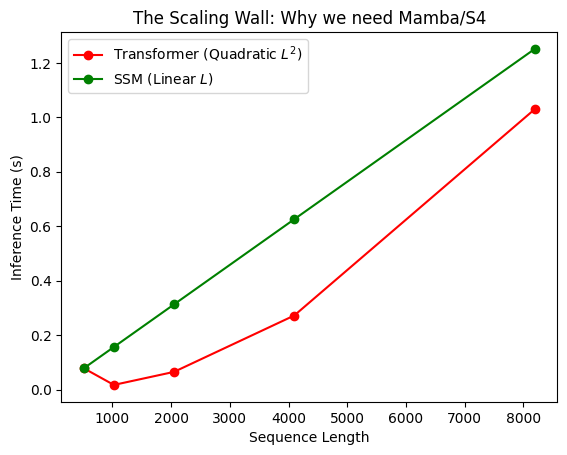

In [4]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def benchmark_transformer(seq_lengths):
    times = []
    for l in seq_lengths:
        # Simple attention-like operation simulation
        x = torch.randn(1, l, 512)
        start = time.time()
        # Simulating self-attention matrix (L x L)
        attn = torch.matmul(x, x.transpose(-1, -2))
        end = time.time()
        times.append(end - start)
    return times

lengths = [512, 1024, 2048, 4096, 8192]
t_times = benchmark_transformer(lengths)
ssm_times = [l * (t_times[0]/lengths[0]) for l in lengths] # Theoretical Linear Scaling

plt.plot(lengths, t_times, 'ro-', label='Transformer (Quadratic $L^2$)')
plt.plot(lengths, ssm_times, 'go-', label='SSM (Linear $L$)')
plt.title("The Scaling Wall: Why we need Mamba/S4")
plt.xlabel("Sequence Length")
plt.ylabel("Inference Time (s)")
plt.legend()
plt.show()

# 2. The Bridge: Discretization
S4 and Mamba are born from continuous-time differential equations. However, digital computers operate in discrete steps ($\Delta$). Discretization is the mathematical bridge that allows us to transform a continuous signal into a sequence of hidden states. A smaller $\Delta$ provides higher fidelity but requires more steps.

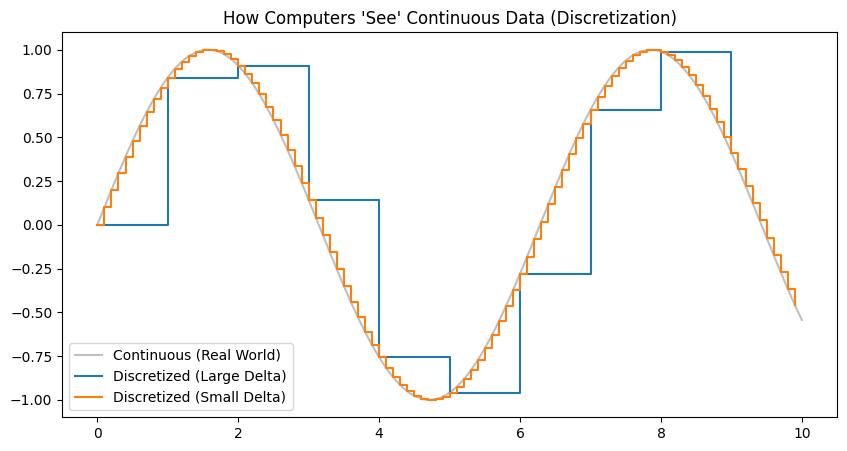

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define a simple continuous signal (like a sound wave)
def continuous_signal(t):
    return np.sin(t)

# 2. This is "Discretization" - choosing how often to 'sample' the wave
# Think of delta (dt) as the 'gap' between our notes.
t_continuous = np.linspace(0, 10, 1000)
delta_large = 1.0  # Big steps (Low quality)
delta_small = 0.1  # Small steps (High quality)

t_large = np.arange(0, 10, delta_large)
t_small = np.arange(0, 10, delta_small)

# 3. Plotting the difference
plt.figure(figsize=(10, 5))
plt.plot(t_continuous, continuous_signal(t_continuous), label='Continuous (Real World)', color='grey', alpha=0.5)
plt.step(t_large, continuous_signal(t_large), label='Discretized (Large Delta)', where='post')
plt.step(t_small, continuous_signal(t_small), label='Discretized (Small Delta)', where='post')
plt.legend()
plt.title("How Computers 'See' Continuous Data (Discretization)")
plt.show()

# 3. The Brain: The HiPPO Matrix

Why not just use an RNN? Standard RNNs 'forget' the past too quickly. The HiPPO (High-Order Polynomial Projection Operators) matrix is the 'Secret Sauce' of S4. It mathematically projects the history of a signal onto Legendre polynomials, ensuring that the model can remember information from thousands of steps ago as clearly as the last step.

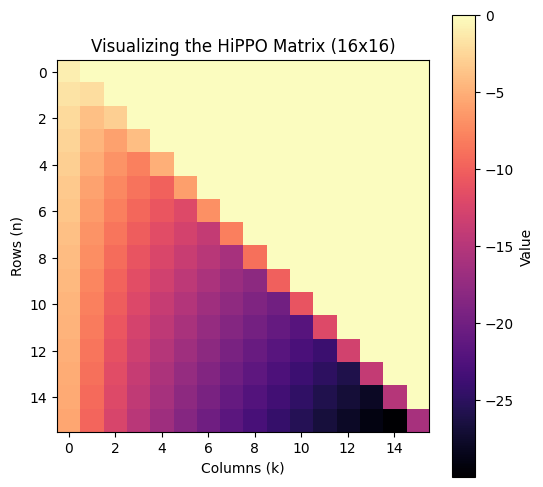

HiPPO Matrix Determinant: 40320.00000000002


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def make_HiPPO(N):
    # This is the exact code you found, just slightly cleaned up for Python 3
    def v(n, k):
        if n > k:
            return np.sqrt(2 * n + 1) * np.sqrt(2 * k + 1)
        elif n == k:
            return n + 1
        else:
            return 0

    mat = [[v(n, k) for k in range(N)] for n in range(N)]
    return -np.array(mat) # We use negative because of the way the math works in the paper

# Let's look at a 16x16 version
N_size = 16
hippo_matrix = make_HiPPO(N_size)

plt.figure(figsize=(6, 6))
plt.imshow(hippo_matrix, cmap='magma')
plt.colorbar(label='Value')
plt.title(f"Visualizing the HiPPO Matrix ({N_size}x{N_size})")
plt.xlabel("Columns (k)")
plt.ylabel("Rows (n)")
plt.show()
print(f"HiPPO Matrix Determinant: {np.linalg.det(hippo_matrix[:8, :8])}")
# Explain: A non-zero determinant shows the matrix is 'rich' in information!

# 4. The "Two Faces" (Recurrence & Convolution)

The ultimate strength of S4 is its Dual Nature.

At Training Time: It acts like a Convolution (CNN). We can process the whole sequence in parallel because the 'A' matrix is fixed.

At Inference Time: It acts like a Recurrence (RNN). We only need the previous 'Hidden State' to predict the next token, leading to 5x faster generation than Transformers.

In [3]:
import numpy as np

# Let's say our memory size (N) is 4
N = 4
A_bar = np.eye(N) * 0.9  # A simple decay: it remembers 90% of the past
B_bar = np.ones((N, 1))   # How much it cares about the new input

# Initial "Summary Notebook" is empty (all zeros)
h = np.zeros((N, 1))

# A sequence of 5 inputs (imagine these are words or audio samples)
inputs = [1.0, 0.5, -0.2, 0.8, -0.1]

print("Starting SSM Recurrence...\n")
for i, x in enumerate(inputs):
    # The Core Equation: New State = (A * Old State) + (B * Input)
    h = (A_bar @ h) + (B_bar * x)

    print(f"Step {i+1} | Input: {x: .1f}")
    print(f"Current State (Summary): {h.flatten()}\n")

Starting SSM Recurrence...

Step 1 | Input:  1.0
Current State (Summary): [1. 1. 1. 1.]

Step 2 | Input:  0.5
Current State (Summary): [1.4 1.4 1.4 1.4]

Step 3 | Input: -0.2
Current State (Summary): [1.06 1.06 1.06 1.06]

Step 4 | Input:  0.8
Current State (Summary): [1.754 1.754 1.754 1.754]

Step 5 | Input: -0.1
Current State (Summary): [1.4786 1.4786 1.4786 1.4786]



## 5. The "Selection" Mechanism (The Mamba Breakthrough)

The models we visualized above (S4) are **LTI (Linear Time-Invariant)**. This means their matrices ($A, B, C$) never change. They are like a fixed filter.

**The Problem:** Language is not invariant. Some words carry more weight than others.
**The Mamba Solution:** Make the parameters ($B, C, \Delta$) functions of the **Input ($x$)**. This allows the model to:
1. **Focus:** Increase $\Delta$ to let the current token influence the state more.
2. **Filter:** Set $B$ or $\Delta$ to near-zero to ignore "filler" words.

This turns the SSM from a simple filter into a **Selective Scan**.

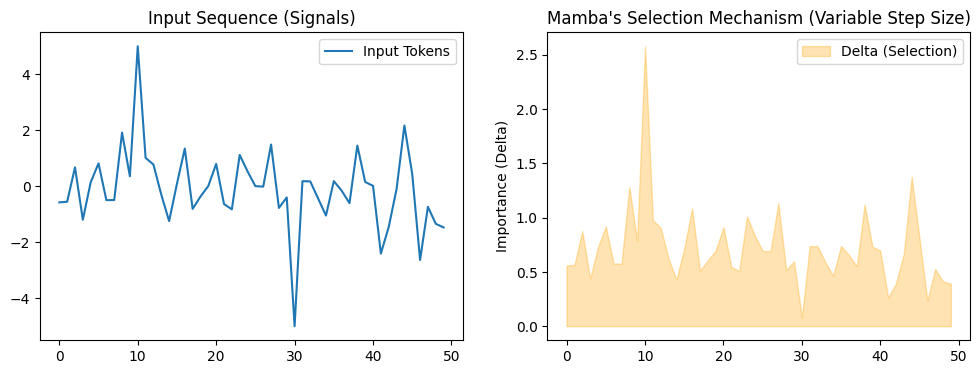

In [6]:
import torch
import torch.nn.functional as F

def visual_selection_demo(sequence_length=50):
    # Simulate an input sequence (Random noise with 2 'important' spikes)
    x = torch.randn(sequence_length)
    x[10] = 5.0  # Important "Word" 1
    x[30] = -5.0 # Important "Word" 2

    # In Mamba, Delta (dt) is input-dependent
    # We'll simulate this: high input = high delta (pay attention)
    dt = F.softplus(x * 0.5)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, label="Input Tokens")
    plt.title("Input Sequence (Signals)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.fill_between(range(sequence_length), dt.numpy(), color='orange', alpha=0.3, label="Delta (Selection)")
    plt.title("Mamba's Selection Mechanism (Variable Step Size)")
    plt.ylabel("Importance (Delta)")
    plt.legend()
    plt.show()

visual_selection_demo()

#Final Conclusion

Through this week's research and implementation, we have established that the **Transformer's quadratic scaling** () is not just a technical hurdle but a fundamental limitation for the future of long-context AI. By revisiting **State Space Models (SSMs)**, we have identified a path toward **linear scaling** () without sacrificing the ability to capture global context.

---



#### 1. The S4 Foundation: Solving the Memory Problem

A standard RNN often suffers from "vanishing gradients" or forgetting. We explored how the **Structured State Space Model (S4)** utilizes the **HiPPO Matrix** (High-Order Polynomial Projection Operators).

* **The "Secret Sauce":** HiPPO allows the model to project the history of a signal onto a mathematical basis (Legendre Polynomials), ensuring the hidden state  maintains a lossless compression of the past.

#### 2. The Duality of Computation: The Best of Both Worlds

We demonstrated that SSMs are "shape-shifters," offering a unique computational duality:

* **Training (Convolution Mode):** Because the parameters are fixed, we can process the entire sequence at once using Fast Fourier Transforms (FFT). This allows for massive parallelization on GPUs.
* **Inference (Recurrent Mode):** During generation, the model switches to a step-by-step  update. This provides constant-time generation regardless of sequence length.

#### 3. The Mamba Evolution: Introducing Selection

While S4 is powerful, it is **Time-Invariant**, meaning it treats every token with the same "weight." Mamba introduces **Selectivity**:

* **Input-Dependent Parameters:** In Mamba,  (step size), , and  are functions of the input .
* **Mechanism:** This allows the model to "choose" what to filter out and what to remember, effectively mimicking the **Attention** mechanism but with the efficiency of an SSM.

#### 4. Hardware Awareness: Defeating the Memory Wall

We identified that Mamba’s speed is not just math—it's engineering.

* **The Bottleneck:** Traditional RNNs are slow because they constantly move data between **HBM** (slow High Bandwidth Memory) and **SRAM** (fast cache).
* **The Solution:** Mamba uses a custom **CUDA Kernel** to perform a **Parallel Associative Scan**, keeping the "Hidden State" updates inside the SRAM to avoid the memory-transfer bottleneck.

---



> **"S4 provided the mathematical skeleton, but Mamba provides the brain."**

By combining **Selective Compression** with **Hardware-Aware Parallel Scans**, Mamba proves that we can achieve Transformer-level quality (or better) while maintaining the lightning-fast efficiency of a linear model. This sets the stage for our upcoming implementation.

---

### Preview: Week 2

In the next phase, we move from theoretical visualization to **implementation**.

We will:

1. Build a functional **S4 Layer** in JAX/PyTorch.
2. Implement the **Discretization logic** to bridge continuous math with discrete code.
3. Prepare for training on our first sequence-based datasets.

# Research & Reference Library

To build this foundation, we analyzed the following seminal works in the State Space Model (SSM) ecosystem.

###  Primary Research Papers

| Paper | Year | Contribution to Project |
| --- | --- | --- |
| **[Mamba: Linear-Time Sequence Modeling](https://arxiv.org/abs/2312.00752)** | 2023 | Introduced **Selection Mechanism** and hardware-aware Parallel Scan. |
| **[S4: Structured State Spaces](https://arxiv.org/abs/2111.00396)** | 2022 | Established the **Parameterization** (NPLR) that makes SSMs stable. |
| **[HiPPO: Recurrent Memory](https://arxiv.org/abs/2008.07669)** | 2020 | Created the mathematical framework for **Optimal Polynomial Projections**. |

### Annotated Guides & Blogs

* **[The Annotated S4 (ICLR Blog Track)](https://iclr-blog-track.github.io/2022/03/25/annotated-s4/)**: A deep dive into the JAX implementation of the S4 model, which served as our primary code reference.
* **[A Visual Guide to Mamba (Maarten Grootendorst)](https://www.maartengrootendorst.com/blog/mamba/)**: Provided the conceptual intuition for the transition from Transformers to Selective SSMs.
* **[SSMphony Repository](https://www.google.com/search?q=https://github.com/SSM11011/SSMphony-AI-voice-generation-using-Mamba-SSMs)**: An applied example of using Mamba for audio generation, highlighting its efficiency with long-form sequences.

### Technology Stack

* **Language:** Python 3.10+
* **Linear Algebra:** NumPy (Visualization) & JAX/PyTorch (Implementation)
* **Visualization:** Matplotlib & Seaborn

